# Previsão de emissão de CO2

## Configuração

Inclusão dos imports necessários.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tabulate

from IPython.display import SVG, HTML, display
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.utils import model_to_dot
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


## Leitura e normalização dos dados

Lendo o arquivo CSV que contém os dados a serem analisados.

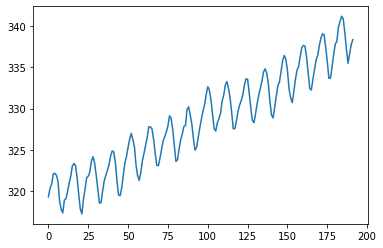

In [2]:
X = pd.read_csv("co2-ppm-mauna-loa-19651980.csv", usecols=[1], sep=",")
plt.plot(X.CO2)
plt.show()

Realizando normalização com `minmax`.

In [3]:
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)

Carregando output (Y) e separando os dados que serão utilizandos no treinamento e teste.

In [4]:
Y = X[1:]
X = X[:len(X)-1]

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, shuffle=False)

In [6]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

## Definição do modelo

Para esse problema, foi implementado uma rede LSTM que utiliza `adam` como optimizer e os estimadores de `mean squared error` e `mean absolute error` como métricas.

In [7]:
class CarbonModel:
    
    def __init__(self):
        
        self.model = None
        self._build_model()
        
    def _build_model(self):
        
        if self.model is None:
            
            self.model = Sequential()
            self.model.add(LSTM(4, input_shape=(1,1)))
            self.model.add(Dense(1))
            self.model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mse", "mae"])
            
    def train(self, X, Y, X_test=None, Y_test=None, epochs=20):
        
        return self.model.fit(
            X,
            Y,
            validation_data=(X_test, Y_test) if X_test is not None and Y_test is not None else None,
            verbose=0,
            batch_size=1,
            epochs=epochs,
        )
    
    def predict(self, X):
        
        return self.model.predict(X)

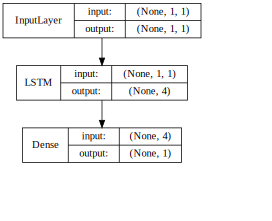

In [8]:
model = CarbonModel()

SVG(model_to_dot(model.model, show_shapes=True, show_layer_names=False).create(prog='dot', format='svg'))

## Treinamento

O processo de treino foi realizado ao longo de 20 épocas.

In [9]:
training_history = model.train(X_train, Y_train, X_test, Y_test, epochs=25)

## Avaliação

Avaliação da métrica `mean squared error`.

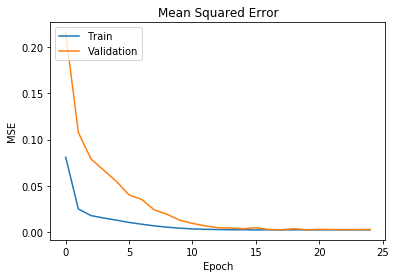

In [10]:
plt.plot(training_history.history["mse"])
plt.plot(training_history.history["val_mse"])
plt.title("Mean Squared Error")
plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()

Avaliação da métrica `mean absolute error`.

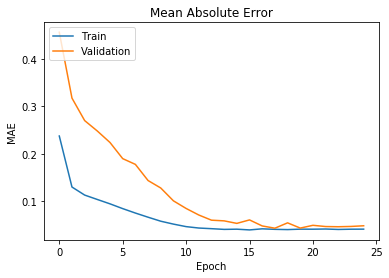

In [11]:
plt.plot(training_history.history["mae"])
plt.plot(training_history.history["val_mae"])
plt.title("Mean Absolute Error")
plt.ylabel("MAE")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()

In [12]:
def evaluate_predict(X, Y, data_type):
    
    prediction = model.predict(X)
    
    plt.plot(prediction)
    plt.plot(Y)
    plt.title(f"Results (with {data_type} Data)")
    plt.legend(["Prediction", "Expected"], loc="upper left")
    plt.show()

Previsão com os dados de treino.

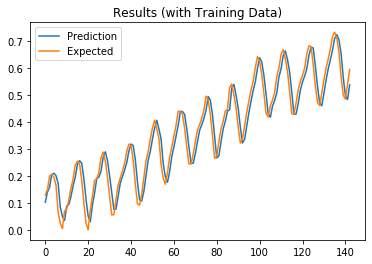

In [13]:
evaluate_predict(X_train, Y_train, "Training")

Previsão com os dados de teste.

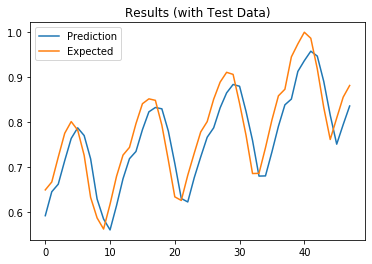

In [14]:
evaluate_predict(X_test, Y_test, "Test")

Verificação dos melhores valores das métricas durante o processo de treinamento.

In [15]:
table = [
    ["Metric",],
    ["MSE training",],
    ["MSE validation",],
    ["MAE training",],
    ["MAE validation",],
    #["R training",],
    #["R test",],
    #["R2 training",],
    #["R2 test",],
]
    
table[0].append("Value")
table[1].append(min(training_history.history['mse']))
table[2].append(min(training_history.history['val_mse']))
table[3].append(min(training_history.history['mae']))
table[4].append(min(training_history.history['val_mae']))
#table[5].append(training_history.history['r_train'][0])
#table[6].append(training_history.history['r_test'][0])
#table[7].append(training_history.history['r2_train'])
#table[8].append(training_history.history['r2_test'])
    
display(HTML(tabulate.tabulate(table, tablefmt="html", headers="firstrow")))

Metric,Value
MSE training,0.00221772
MSE validation,0.0023927
MAE training,0.039794
MAE validation,0.0433837
